##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Personalized Product Descriptions with Weaviate and the Gemini API

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/weaviate/personalized_description_with_weaviate_and_gemini_api.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

Weaviate is an open-source vector database that enables you to build AI-powered applications with the Gemini API! This notebook has four parts:
1. [Part 1: Connect to Weaviate, Define Schema, and Import Data](#part-1-install-dependencies-and-connect-to-weaviate)

2. [Part 2: Run Vector Search Queries](#part-2-vector-search)

3. [Part 3: Generative Feedback Loops](#part-3-generative-feedback-loops)

4. [Part 4: Personalized Product Descriptions](#part-4-personalization)


In this demo, you will learn how to embed your data, run a semantic search, make a generative call to the Gemini API and store the output in your vector database, and personalize the description based on the user profile.

## Use Case

You will be working with an e-commerce dataset containing Google merch. You will load the data into the Weaviate vector database and use the semantic search features to retrieve data. Next, you'll generate product descriptions and store them back into the database with a vector embedding for retrieval (aka, generative feedback loops). Lastly, you'll create a small knowledge graph with uniquely generated product descriptions for the buyer personas Alice and Bob.

## Requirements
You will need a running Weaviate cluster and Gemini API key. You'll set up these requirements as you progress through this notebook!

1. Weaviate vector database
    1. Serverless
    1. Embedded
    1. Local (Docker)
1. Gemini API key
    1. Create an API key via [AI Studio](https://aistudio.google.com/)

## Video
**For an awesome walk through of this demo, check out [this](https://youtu.be/WORgeRAAN-4?si=-WvqNkPn8oCmnLGQ&t=1138) presentation from Google Cloud Next!**

[![From RAG to autonomous apps with Weaviate and Gemini API on Google Kubernetes Engine](http://i3.ytimg.com/vi/WORgeRAAN-4/hqdefault.jpg)](https://youtu.be/WORgeRAAN-4?si=-WvqNkPn8oCmnLGQ&t=1138)

## Install Dependencies and Libraries

In [ ]:
%pip install weaviate-client==4.7.1
%pip install -U -q "google-genai>=1.0.0"
%pip install requests
%pip install 'protobuf>=5'

In [3]:
import weaviate
from weaviate.classes.config import Configure
from weaviate.embedded import EmbeddedOptions
import weaviate.classes as wvc
from weaviate.classes.config import Property, DataType, ReferenceProperty
from weaviate.util import generate_uuid5
from weaviate.classes.query import QueryReference

import os
import json
import requests
import PIL
import IPython

from PIL import Image
from io import BytesIO
from IPython.display import Markdown

# Convert image links to PIL object
def url_to_pil(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

# display images
def display_image(url, size=100):
    response = requests.get(url)
    image_data = BytesIO(response.content)
    image = Image.open(image_data)

    resized_image = image.resize((size,size))

    display(resized_image)

## Part 1: Connect to Weaviate, Define Schema, and Import Data

### Connect to Weaviate

You will need to create a Weaviate cluster. There are a few ways to do this:

1. [Weaviate Embedded](https://weaviate.io/developers/weaviate/installation/embedded): Run Weaviate in your runtime

2. [Weaviate Cloud](console.weaviate.cloud): Create a sandbox on our managed service. You will need to deploy it in US West, US East, or Australia.

3. Local Host: [Docker](https://weaviate.io/developers/weaviate/installation/docker-compose#starter-docker-compose-file) or [Kubernetes](https://weaviate.io/developers/weaviate/installation/kubernetes)

For the full list of installation options, see [this page](https://weaviate.io/developers/weaviate/installation).

#### Weaviate Embedded
You will default to Weaviate Embedded. This runs Weaviate inside your notebook and is ideal for quick experimentation.

**Note: It will disconnect once you stop the terminal.**

**Set up your API key**

To run the following cell, your Gemini API key must be stored in a Colab Secret and named `GEMINI_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [4]:
from google import genai
from google.colab import userdata

GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")
gemini_client = genai.Client(api_key=GEMINI_API_KEY)

In [5]:
client = weaviate.WeaviateClient(
    embedded_options=EmbeddedOptions(
        version="1.25.10",
        additional_env_vars={
            "ENABLE_MODULES": "text2vec-palm, generative-palm"
        }),
        additional_headers={
            "X-Google-Studio-Api-Key": GEMINI_API_KEY
        }
)

client.connect()

INFO:weaviate-client:Binary /root/.cache/weaviate-embedded did not exist. Downloading binary from https://github.com/weaviate/weaviate/releases/download/v1.25.10/weaviate-v1.25.10-Linux-amd64.tar.gz
INFO:weaviate-client:Started /root/.cache/weaviate-embedded: process ID 716


#### Other Options: Weaviate Cloud and Local Host

#### **Weaviate Cloud**

You can connect your notebook to a serverless Weaviate cluster to keep the data persistent in the cloud. You can register [here](https://console.weaviate.cloud/) and create a free 14-day sandbox!

To connect to your WCD cluster:
```python
WCD_URL = "https://sandbox.gcp.weaviate.cloud"
WCD_AUTH_KEY = "sk-key"
GEMINI_API_KEY = "sk-key"

client = weaviate.connect_to_wcs(
    cluster_url=WCD_URL,
    auth_credentials=weaviate.auth.AuthApiKey(WCD_AUTH_KEY),
    headers={"X-Google-Studio-Api-Key": GEMINI_API_KEY},
)

print(client.is_ready())
```

#### **Local Host**

If you want to run Weaviate yourself, you can download the [Docker files](https://weaviate.io/developers/weaviate/installation/docker-compose) and run it locally on your machine or in the cloud. There is also a `yaml` file in this folder you can use.

To connect to Weaviate locally:
```python
client = weaviate.connect_to_local()

print(client.is_ready())
```

### Create schema
The schema tells Weaviate how you want to store your data.

You will first create two collections: Products and Personas. Each collection has metadata (properties) and specifies the embedding and language model.

In [Part 4](#part-4-personalization), you will create another collection, `Personalized`, that will generate product descriptions based on the persona.

In [6]:
# This is optional to empty your database
result = client.collections.delete("Products")
print(result)
result = client.collections.delete("Personas")
print(result)

None
None


In [7]:
PROJECT_ID = "" # leave this empty
API_ENDPOINT = "generativelanguage.googleapis.com"
embedding_model = "text-embedding-004" # embedding model
generative_model = "gemini-1.5-flash-latest" # language model

# Products Collection
if not client.collections.exists("Products"):
  collection = client.collections.create(
    name="Products",
    vectorizer_config=Configure.Vectorizer.text2vec_palm
    (
        project_id=PROJECT_ID,
        api_endpoint=API_ENDPOINT,
        model_id = embedding_model
    ),
    generative_config=Configure.Generative.palm(
        project_id=PROJECT_ID,
        api_endpoint=API_ENDPOINT,
        model_id = generative_model
    ),
    properties=[ # properties for the Products collection
            Property(name="product_id", data_type=DataType.TEXT),
            Property(name="title", data_type=DataType.TEXT),
            Property(name="category", data_type=DataType.TEXT),
            Property(name="link", data_type=DataType.TEXT),
            Property(name="description", data_type=DataType.TEXT),
            Property(name="brand", data_type=DataType.TEXT),
            Property(name="generated_description", data_type=DataType.TEXT),
      ]
  )

# Personas Collection
if not client.collections.exists("Personas"):
  collection = client.collections.create(
    name="Personas",
    vectorizer_config=Configure.Vectorizer.text2vec_palm
    (
        project_id=PROJECT_ID,
        api_endpoint=API_ENDPOINT,
        model_id = embedding_model
    ),
    generative_config=Configure.Generative.palm(
        project_id=PROJECT_ID,
        api_endpoint=API_ENDPOINT,
        model_id = generative_model
    ),
    properties=[ # properties for the Personas collection
            Property(name="name", data_type=DataType.TEXT),
            Property(name="description", data_type=DataType.TEXT),
      ]
  )

### Import Objects

In [8]:
# URL to the raw JSON file
url = 'https://raw.githubusercontent.com/bkauf/next-store/main/first_99_objects.json'
response = requests.get(url)

# Load the entire JSON content
data = json.loads(response.text)

In [9]:
# Print first object
data[0]

{'id': 'id_1',
 'product_id': 'GGOEGAYC135814',
 'title': 'Google Badge Tee',
 'category': 'Apparel  Accessories Tops  Tees Tshirts',
 'link': 'https://shop.googlemerchandisestore.com/store/20160512512/assets/items/images/GGOEGXXX1358.jpg',
 'description': 'A classic crew neck tee made from 100 cotton Its soft and comfortable and features a small Google logo on the chest',
 'color': "['Blue']",
 'gender': 'Unisex',
 'brand': 'Google'}

#### Upload to Weaviate

To make sure everything is set, you will upload only one object and confirm it's in the database.

In [10]:
products = client.collections.get("Products")

first_object = data[0]

products.data.insert(
    properties={
        "product_id": first_object['product_id'],
        "title": first_object['title'],
        "category": first_object['category'],
        "link": first_object['link'],
        "description": first_object['description'],
        "brand": first_object['brand']
    }
)

response = products.aggregate.over_all(total_count=True)
print(response.total_count) # This should output 1

1


Let's import the remainder of our dataset. You will use Weaviate's batch import to get the 98 objects into our database.

In [11]:
products = client.collections.get("Products")

remaining_data = data[1:]

with products.batch.dynamic() as batch:
  for item in remaining_data:
    batch.add_object(
      properties={
        "product_id": item['product_id'],
        "title": item['title'],
        "category": item['category'],
        "link": item['link'],
        "description": item['description'],
        "brand": item['brand']
    }
  )

response = products.aggregate.over_all(total_count=True)
print(response.total_count) # this should print 99

99


In [12]:
# print the first object uuid and properties to analyze how data is structured
first_product = next(products.iterator())
print(first_product.uuid,"\n", json.dumps(first_product.properties, indent=4))

000db09a-3e33-462d-be03-5715d9cde529 
 {
    "description": "The unisex Waze logo hoodie is a perfect way to show your love for the Waze app The hoodie is made of a soft and comfortable cotton blend and features a kangaroo pocket and a drawstring hood The Waze logo is embroidered on the front of the hoodie",
    "generated_description": null,
    "product_id": "GGCPWAEJ402614",
    "link": "https://shop.googlemerchandisestore.com/store/20190522377/assets/items/images/GGCPWXXX4026.jpg",
    "category": "Clothing Unisex Clothing Hoodies  Sweatshirts",
    "title": "Unisex Waze Logo Hoodie",
    "brand": "Waze"
}


You will fetch the object by the UUID that was created. It will print out the vector embedding as well!

In [13]:
product = products.query.fetch_object_by_id(
    first_product.uuid,
    include_vector=True
)

print(f"Product: {product.properties['title']}")
print(f"Vector Dimensionality: {len(product.vector['default'])}")
print(f"Vector Preview: {product.vector['default'][:50]} ...")

Product: Unisex Waze Logo Hoodie
Vector Dimensionality: 768
Vector Preview: [0.000302837259368971, -0.009837448596954346, 0.022877082228660583, -0.012845730409026146, 0.03479452058672905, 0.06852656602859497, 0.023823168128728867, -0.008967291563749313, -0.007616781629621983, 0.03446043282747269, -0.03289780020713806, -0.041297584772109985, 0.047338180243968964, -0.007135987281799316, 0.03441719338297844, -0.09767945110797882, -0.02126118168234825, 0.041591379791498184, -0.04611879959702492, -0.040249183773994446, -0.032080017030239105, -0.04292743653059006, 0.03954688459634781, -0.04586683586239815, -0.008462391793727875, 0.010463248938322067, 0.021219832822680473, 0.04991120845079422, 0.00274534709751606, -0.02430199831724167, 0.07378753274679184, 0.015373442322015762, -0.03711485117673874, -0.021959325298666954, 0.030712256208062172, -0.029576774686574936, -0.023318929597735405, 0.003632798558101058, -0.012349340133368969, -0.054480548948049545, -0.037265971302986145, 0.048531770706

## Part 2: Vector Search

### Vector Search
Vector search returns the objects with most similar vectors to that of the query. You will use the `near_text` operator to find objects with the nearest vector to an input text.

{
  "title": "Google Campus Bike Mug",
  "description": "The Google Campus Bike Corkbase Mug is a blue mug with a cork bottom It features a design of a yellow bicycle with a basket on the front The mug is perfect for coffee tea or any other hot beverage",
  "link": "https://shop.googlemerchandisestore.com/store/20160512512/assets/items/images/GGOEGDWC122799.jpg"
}


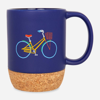

===
{
  "title": "Google San Francisco Mug",
  "description": "The Google San Francisco Mug is a black and white mug with the Google logo on it It is made of ceramic and is dishwasher safe",
  "link": "https://shop.googlemerchandisestore.com/store/20160512512/assets/items/images/GGOEGDWJ146799.jpg"
}


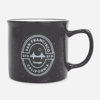

===
{
  "description": "The YETI Rambler 20 oz Tumbler is made of stainless steel and has a doublewall vacuum insulation to keep drinks cold for up to 24 hours and hot for up to 12 hours It is also dishwashersafe for easy cleaning The tumbler is silver and has the Google Cloud Certified logo on it",
  "title": "Google Cloud Certified Professional Security Engineer Tumbler",
  "link": "https://shop.googlemerchandisestore.com/store/20230615372/assets/items/images/GGCLCDNJ121099.jpg"
}


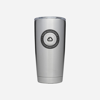

===


In [14]:
products = client.collections.get("Products")

response = products.query.near_text(
        query="travel mug",
        return_properties=["title", "description", "link"], # only return these 3 properties
        limit=3 # limited to 3 objects
)

for product in response.objects:
    print(json.dumps(product.properties, indent=2))
    display_image(product.properties['link'])
    print('===')

### Hybrid Search
[Hybrid search](https://weaviate.io/developers/weaviate/search/hybrid) combines keyword (BM25) and vector search together, giving you the best of both algorithms.

To use hybrid search in Weaviate, all you have to do is define the `alpha` parameter to determine the weighting.

`alpha` = 0 --> pure BM25

`alpha` = 0.5 --> half BM25, half vector search

`alpha` = 1 --> pure vector search

{
  "title": "Create Design Code Build Cork Bottom Tumbler",
  "description": "This black tumbler is made of stainless steel and has a cork bottom It is perfect for keeping your drinks hot or cold for hours The tumbler is also dishwasher safe for easy cleaning",
  "link": "https://shop.googlemerchandisestore.com/store/20160512512/assets/items/images/GGOEGDNB198099.jpg"
}


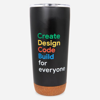

===
{
  "description": "The Google San Francisco Mug is a black and white mug with the Google logo on it It is made of ceramic and is dishwasher safe",
  "title": "Google San Francisco Mug",
  "link": "https://shop.googlemerchandisestore.com/store/20160512512/assets/items/images/GGOEGDWJ146799.jpg"
}


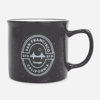

===
{
  "description": "The Sip by Swell 17oz Stainless Steel Water Bottle is made of doublewalled vacuuminsulated stainless steel and features a leakproof design It keeps drinks cold for up to 24 hours and hot for up to 12 hours The bottle has a wide mouth opening for easy filling and cleaning and a builtin carrying loop for easy transport The Google Cloud logo is printed on the front of the bottle",
  "title": "Google Cloud Sip by Swell 17oz Stainless Steel Water Bottle",
  "link": "https://shop.googlemerchandisestore.com/store/20210125633/assets/items/images/GGEBCCBA112199.jpg"
}


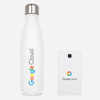

===


In [15]:
products = client.collections.get("Products")

response = products.query.hybrid(
    query = "dishwasher safe container", # query
    alpha = 0.75, # leaning more towards vector search
    return_properties=["title", "description", "link"], # return these 3 properties
    limit = 3 # limited to only 3 objects
)

for product in response.objects:
    print(json.dumps(product.properties, indent=2))
    display_image(product.properties['link'])
    print('===')

### Autocut
Rather than hard-coding the limit on the number of objects (seen above), the [autocut](https://weaviate.io/developers/weaviate/api/graphql/additional-operators#autocut) feature can be used to cut off the result set. Autocut limits the number of results returned based on significant variations in the result set's metrics, such as vector distance or score.


To use autocut, you must specify the `auto_limit` parameter, which will stop returning results after the specified number of variations, or "jumps" is reached.

You will use the same hybrid search query above but use `auto_limit` rather than `limit`. Notice how there are actually 4 objects retrieved in this case, compared to the 3 objects returned in the previous query.

{
  "description": "This black tumbler is made of stainless steel and has a cork bottom It is perfect for keeping your drinks hot or cold for hours The tumbler is also dishwasher safe for easy cleaning",
  "title": "Create Design Code Build Cork Bottom Tumbler",
  "link": "https://shop.googlemerchandisestore.com/store/20160512512/assets/items/images/GGOEGDNB198099.jpg"
}


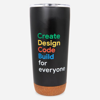

===


In [16]:
# auto_limit set to 1

products = client.collections.get("Products")

response = products.query.hybrid(
    query = "dishwasher safe container", # query
    alpha = 0.75, # leaning more towards vector search
    return_properties=["title", "description", "link"], # return these 3 properties
    auto_limit = 1 # autocut after 1 jump
)

for product in response.objects:
    print(json.dumps(product.properties, indent=2))
    display_image(product.properties['link'])
    print('===')

### Filters
Narrow down the results by adding a filter to the query.

Find objects where `category` is equal to `drinkware`.

{
  "category": "Drinkware Tumblers",
  "description": "The SPEAR Vacuum Insulated Tumbler is made of stainless steel and has a capacity of 16 ounces It is white and has a blue and purple SPEAR logo on it",
  "title": "SPEAR Vacuum Insulated Tumbler",
  "link": "https://shop.googlemerchandisestore.com/store/20190522377/assets/items/images/GGCPGDNQ201799.jpg"
}


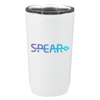

===
{
  "category": "Drinkware Bottles",
  "title": "Google Cloud Sip by Swell 17oz Stainless Steel Water Bottle",
  "description": "The Sip by Swell 17oz Stainless Steel Water Bottle is made of doublewalled vacuuminsulated stainless steel and features a leakproof design It keeps drinks cold for up to 24 hours and hot for up to 12 hours The bottle has a wide mouth opening for easy filling and cleaning and a builtin carrying loop for easy transport The Google Cloud logo is printed on the front of the bottle",
  "link": "https://shop.googlemerchandisestore.com/store/20210125633/assets/items/images/GGEBCCBA112199.jpg"
}


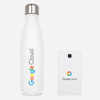

===
{
  "category": "Drinkware",
  "description": "This black tumbler is made of stainless steel and has a cork bottom It is perfect for keeping your drinks hot or cold for hours The tumbler is also dishwasher safe for easy cleaning",
  "title": "Create Design Code Build Cork Bottom Tumbler",
  "link": "https://shop.googlemerchandisestore.com/store/20160512512/assets/items/images/GGOEGDNB198099.jpg"
}


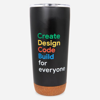

===


In [17]:
products = client.collections.get("Products")

response = products.query.near_text(
    query="travel cup",
    return_properties=["title", "description", "category", "link"], # returned properties
    filters=wvc.query.Filter.by_property("category").equal("Drinkware"), # filter
    limit=3, # limit to 3 objects
)

for product in response.objects:
    print(json.dumps(product.properties, indent=2))
    display_image(product.properties['link'])
    print('===')

## Part 3: Generative Feedback Loops

[Generative Feedback Loops](https://weaviate.io/blog/generative-feedback-loops-with-llms) refers to the process of storing the output from the language model back to the database.

You will generate a description for each product in our database using the Gemini API and save it to the `generated_description` property in the `Products` collection.

### Connect and configure the Gemini API model

Make sure you have initialized your Gemini Client. Please confirm this step was done in [Part 1](#part-1-connect-to-weaviate-define-schema-and-import-data).

### Generate a description and store it in the `Products` collection

Steps for the below cell:
1. Run a vector search query to find travel jackets
    * Learn more about autocut (`auto_limit`) [here](https://weaviate.io/developers/weaviate/api/graphql/additional-operators#autocut).

2. Grab the returned objects, prompt the Gemini API with the task and image, store the description in the `generated_description` property

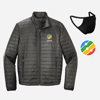

Okay, here's a short Facebook ad based on the image:

**Option 1 (Focus on style and functionality):**

Image: (Product Photo)

Text:

> Gear up for cooler weather with our custom-branded lightweight puffer jacket!  Stay warm and represent your brand in style.  Perfect for employees, clients, or events. Add a matching face mask for complete protection. Get your quote today!  #brandedapparel #companygear #promotionalproducts #customjacket #employeeappreciation

**Option 2 (Emphasis on customization):**

Image: (Product Photo)

Text:

> Looking for a way to promote your business?  Our custom apparel is a great way to put your brand on display!  Get your logo embroidered on our high-quality jackets and masks.  Stand out from the crowd! Click to learn more and get a free quote! #customlogo #brandmerchandise #marketingideas #businessgifts #corporatewear

**Option 3 (Short & Sweet)**

Image: (Product Photo)

Text:

>Stay warm and represent your brand!  Custom jackets and masks available now.

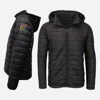

Here are a few options for a short Facebook ad for the jacket pictured:

**Option 1 (Focus on style and warmth):**

Image: The provided photo
Text: Stay warm AND stylish this season! Check out our new quilted jacket. Perfect for layering and showing off your brand logo. Shop now! [Link to product page]

**Option 2 (Focus on customization):**

Image: The provided photo
Text: Looking for branded apparel?  Get your logo on this sleek, comfortable jacket. Great for your team or as promotional swag.  Inquire today! [Link to contact/inquiry page]

**Option 3 (Short & Sweet):**

Image: The provided photo
Text: New Jacket Alert!  Customizable and perfect for cooler weather.  Shop now! [Link to product page]

**Tips for improvement:**

*   **Targeting:** Use Facebook's targeting options to reach people interested in outerwear, corporate apparel, or specific industries.
*   **Call to Action:** Make sure your "Shop Now" or "Inquire Today" button is prominent.
*   **A/B Testing:** Try different ad

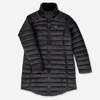

Okay, here's a short Facebook ad for the black puffer coat with the Google logo:

**Option 1 (Focus on warmth and style):**

Image: [The image of the coat]

Headline: Stay Warm, Stay Stylish.

Body: Brave the cold in our sleek black puffer coat! Featuring a subtle Google logo, this coat is perfect for layering. Limited quantities available.

Button: Shop Now

**Option 2 (Focus on brand and functionality):**

Image: [The image of the coat]

Headline: Gear Up with Google!

Body: Check out our new black puffer coat. Lightweight, warm, and sporting the iconic Google logo. Perfect for everyday wear!

Button: Learn More

**Option 3 (Short and Sweet):**

Image: [The image of the coat]

Headline: New Google Coat!

Body: Stay warm and rep your favorite brand. Grab yours now!

Button: Shop Now

**Notes:**

*   I kept the language concise and action-oriented, as Facebook ads need to grab attention quickly.
*   The "Shop Now" or "Learn More" button is crucial for driving traffic to the product pag

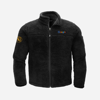

Okay, here are a couple of options for a Facebook ad for that fleece jacket:

**Option 1 (Focus on Exclusivity):**

Headline:  Limited Edition Google Fleece - Get Yours Now!

Body:  Stay warm and stylish with this exclusive Google employee fleece jacket. Super soft, high quality, and only available while supplies last.  Grab yours before they're gone! #Google #Fleece #EmployeeGear #LimitedEdition #TechStyle

**Option 2 (Focus on Comfort & Function):**

Headline: Stay Cozy with the Google Fleece Jacket!

Body:  Perfect for chilly days, this super-soft fleece is designed with comfort and functionality in mind. Sport that tech look with this official fleece, featuring the Google logo.  Shop now and upgrade your wardrobe! #Google #FleeceJacket #TechGear #WinterFashion #ComfortStyle

**Why these work:**

*   **Clear Value Proposition:** Each ad highlights the key benefits (exclusivity/comfort)
*   **Strong Call to Action:** Encourages immediate action ("Get Yours Now!", "Shop Now!")
*   **R

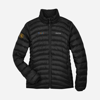

Okay, here are a few options for a Facebook ad based on the image, with varying levels of specificity and targeting.

**Option 1 (Focus on Quality & Prestige):**

```
Image: [Image of the jacket]

Headline: Stay Warm in Style: Marmot for Google

Body:  Experience the ultimate in warmth and performance with this Marmot down jacket.  Featuring the Google logo, this jacket is a perfect blend of comfort and modern style.  Limited quantities available!

Call to Action: Learn More
```

**Option 2 (Focus on Exclusivity and targeted to Google employees):**

```
Image: [Image of the jacket]

Headline: Google Employee Exclusive: Marmot Down Jacket

Body: Stay warm and rep Google with this Marmot down jacket. Featuring the iconic Google logo, this jacket is only available to Google Employees.

Call to Action: Check Availability
```

**Option 3 (Short & Sweet - Broad Appeal):**

```
Image: [Image of the jacket]

Headline:  Stylish and Warm Jacket - Limited Stock!

Body:  Stay cozy this season with

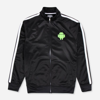

Here are a few options for a Facebook ad:

**Option 1 (Focus on style):**

Headline: Level Up Your Look: Android Jacket

Body: Show your Android pride with this sleek track jacket. Featuring a classic design with a modern twist. Grab yours now and stand out from the crowd!

Call to Action: Shop Now

**Option 2 (Focus on community):**

Headline: Rep Your Favorite OS!

Body: Are you team Android? Show your allegiance with this limited edition track jacket.  Comfortable, stylish, and the perfect way to connect with fellow Android enthusiasts.

Call to Action: Learn More

**Option 3 (Short and sweet):**

Headline: Android Style is Here!

Body: Rock the Android look with this awesome jacket. Get yours today!

Call to Action:  Shop Now

===


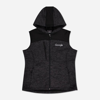

Okay, here's a short Facebook ad for the hoodie vest in the picture:

**Headline:** Stay Warm & Stylish: Limited Edition Google Vest!

**Body:** Gear up for cooler weather with this sleek, comfortable hooded vest. Features a modern design, a cozy hood, and the iconic Google logo. Perfect for layering or wearing on its own. Get yours before they're gone!

**Call to Action:** Shop Now! [Link to product page]

**Targeting suggestions:**
*   Interests: Google, Technology, Outerwear, Activewear
*   Demographics: People who work at Google or have an interest in Google

===


In [19]:
response = products.query.near_text( # first find travel jackets
    query="travel jacket",
    return_properties=["title", "description", "category", "link"],
    auto_limit=1, # limit it to 1 close group
)

for product in response.objects:
    if "link" in product.properties:
        id = product.uuid
        img_url = product.properties["link"]

        pil_image = url_to_pil(img_url) # convert image to PIL object
        generated_description = gemini_client.models.generate_content(
            model="gemini-2.0-flash",
            contents=[
                "Write a short Facebook ad about this product photo.",
                pil_image
            ]
        ) # prompt to the Gemini API
        generated_description = generated_description.text
        display_image(product.properties['link'])
        print(generated_description)
        print('===')

        # Update the Product collection with the generated description
        products.data.update(
            uuid=id,
            properties={"generated_description": generated_description}
        )

### Vector Search on the `generated_description` property

Since the product description was saved in our `Products` collection, you can run a vector search query on it.

In [20]:
products = client.collections.get("Products")

response = products.query.near_text(
        query="travel jacket",
        return_properties=["generated_description", "description", "title"],
        limit=1
    )

for o in response.objects:
    print(o.uuid)
    print(json.dumps(o.properties, indent=2))

56ab6aa2-a2d7-4f9e-a08a-40444a80cae4
{
  "description": "This GON jacket is a stylish and functional piece of outerwear It is made of highquality materials and features a waterresistant finish The jacket also has a number of pockets for storing your belongings The jacket is perfect for a variety of occasions whether youre going to work or just running errands",
  "title": "GON Jacket",
  "generated_description": "Okay, here's a short Facebook ad based on the image:\n\n**Option 1 (Focus on style and functionality):**\n\nImage: (Product Photo)\n\nText:\n\n> Gear up for cooler weather with our custom-branded lightweight puffer jacket!  Stay warm and represent your brand in style.  Perfect for employees, clients, or events. Add a matching face mask for complete protection. Get your quote today!  #brandedapparel #companygear #promotionalproducts #customjacket #employeeappreciation\n\n**Option 2 (Emphasis on customization):**\n\nImage: (Product Photo)\n\nText:\n\n> Looking for a way to promo

## Part 4: Personalization

So far, you've generated product descriptions using the Gemini API with the `gemini-2.0-flash` model. In Part 4, you will generate product descriptions tailored to the persona.

You will use [cross-references](https://weaviate.io/developers/weaviate/manage-data/cross-references) to establish directional relationships between the Products and Personas collections.

In [21]:
result = client.collections.delete("Personalized")
print(result)

None


In [22]:
PROJECT_ID = "" # leave this empty
API_ENDPOINT = "generativelanguage.googleapis.com"
embedding_model = "text-embedding-004" # embedding model
generative_model = "gemini-1.5-flash-latest"

# Personalized Collection

if not client.collections.exists("Personalized"):
  collection = client.collections.create(
    name="Personalized",
    vectorizer_config=Configure.Vectorizer.text2vec_palm(
        project_id=PROJECT_ID,
        api_endpoint=API_ENDPOINT,
        model_id = embedding_model
    ),
    generative_config=Configure.Generative.palm(
        project_id=PROJECT_ID,
        api_endpoint=API_ENDPOINT,
        model_id = generative_model
    ),
    properties=[
            Property(name="description", data_type=DataType.TEXT),
    ],
    # cross-references
    references=[
        ReferenceProperty(
            name="ofProduct",
            target_collection="Products" # connect personalized to the products collection
        ),
        ReferenceProperty(
            name="ofPersona",
            target_collection="Personas" # connect personalized to the personas collection
        )
    ]
)

### Create two personas (Alice and Bob)

In [23]:
personas = client.collections.get("Personas")

for persona in ['Alice', 'Bob']:
  generated_description = gemini_client.models.generate_content(
      model="gemini-2.0-flash",
      contents=[
          "Create a fictional buyer persona named "
          + persona + ", write a short description about them"
      ]
  ) # use gemini-2.0-flash to generate persona description
  uuid = personas.data.insert({
    "name": persona,
    "description": generated_description.text
  })
  print(uuid)
  print(generated_description.text)
  print("===")

e2c96468-aed0-4ca7-92a3-274e77ee6972
## Alice, the Sustainable Style Seeker

**Description:**

Alice is a 28-year-old graphic designer living in a bustling city. She's driven, creative, and deeply passionate about ethical and sustainable living. Having seen firsthand the impact of fast fashion on the environment and garment workers, she's committed to building a wardrobe that's both stylish and kind. She's not necessarily looking for cheap, but she *is* looking for value – pieces that are high-quality, versatile, and made with sustainable materials and fair labor practices. Alice is active on social media, particularly Instagram and Pinterest, where she seeks inspiration for her personal style and connects with like-minded individuals. She values transparency and authenticity in brands, and is willing to invest in products that align with her values, even if they come with a slightly higher price tag.

===
587cc5a5-8876-48d9-8b1d-1cb70c697c2c
## Meet Bob: The Data-Driven Dad

**Descrip

In [24]:
# print objects in the Personas collection

personas = client.collections.get("Personas")

for persona in personas.iterator():
    print(persona.uuid, persona.properties)

587cc5a5-8876-48d9-8b1d-1cb70c697c2c {'description': '## Meet Bob: The Data-Driven Dad\n\n**Description:**\n\nBob is a 45-year-old Marketing Manager at a mid-sized manufacturing company. He\'s a practical, analytical guy who trusts data and measurable results. Outside of work, he\'s a dedicated husband and father of two teenagers. He enjoys grilling, coaching his son\'s little league team, and staying on top of the latest tech trends to impress his kids (and stay ahead of the curve at work). He\'s increasingly frustrated with the inefficiency of his current marketing software and is actively looking for a solution that will streamline processes, provide actionable insights, and ultimately, demonstrate a clear ROI to his boss and the executive team. Bob values efficiency, transparency, and anything that will free up more time for him to spend with his family. He\'s wary of "shiny object syndrome" and prefers proven solutions with strong user reviews and case studies.\n', 'name': 'Bob'}


### Generate a product description tailored to the persona

Grab the product uuid from Part 1 and paste it below

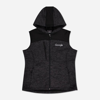

Okay, here's a product description for the Google Women's Tech Fleece Vest, tailored for Bob:

**Google Women's Tech Fleece Vest: Smart Layering for the Active (and Efficient!) Dad**

Bob, we know you're a busy guy – Marketing Manager, coach, dad – you're always on the go. That's why you need gear that can keep up. This Google Women's Tech Fleece Vest isn't just stylish; it's a smart, practical addition to your wife's wardrobe.

Here's why this vest is a win for *her* and, indirectly, a win for *you*:

*   **Layering Made Easy (and Efficient):** This vest is perfect for those cool mornings at the baseball field or evenings grilling out back. It's lightweight enough to layer without bulk, meaning less fuss and more time enjoying the game (or the perfectly cooked burger!).

*   **Data-Backed Comfort:** The soft fleece lining provides warmth without overheating, and the water-resistant finish means she's protected from light rain. No more last-minute dashes inside because of a drizzle!

*

In [25]:
personalized = client.collections.get("Personalized")

product = products.query.fetch_object_by_id(product.uuid)
display_image(product.properties['link'])

personas = client.collections.get("Personas")

for persona in personas.iterator():
    generated_description = gemini_client.models.generate_content(
        model="gemini-2.0-flash",
        contents=[
            """
              Create a product description tailored to the following person,
              make sure to use the name (
            """,
            persona.properties["name"],") of the persona.\n\n",
            "# Product Description\n",
            product.properties["description"], "# Persona",
            persona.properties["description"]]
    ) # generate a description tailored to the persona
    print(generated_description.text)
    print('====')
    # Add the personalized description to the `description` property in the Personalized collection
    new_uuid = personalized.data.insert(
        properties={
            "description": generated_description.text },
        references={
            "ofProduct": product.uuid, # add cross-reference to the Product collection
            "ofPersona": persona.uuid # add cross-reference to the Persona collection
        },
    )


### Fetch the objects in the `Personalized` collection

{'description': "Okay, here's a product description for the Google Women's Tech Fleece Vest, tailored for Bob:\n\n**Google Women's Tech Fleece Vest: Smart Layering for the Active (and Efficient!) Dad**\n\nBob, we know you're a busy guy – Marketing Manager, coach, dad – you're always on the go. That's why you need gear that can keep up. This Google Women's Tech Fleece Vest isn't just stylish; it's a smart, practical addition to your wife's wardrobe.\n\nHere's why this vest is a win for *her* and, indirectly, a win for *you*:\n\n*   **Layering Made Easy (and Efficient):** This vest is perfect for those cool mornings at the baseball field or evenings grilling out back. It's lightweight enough to layer without bulk, meaning less fuss and more time enjoying the game (or the perfectly cooked burger!).\n\n*   **Data-Backed Comfort:** The soft fleece lining provides warmth without overheating, and the water-resistant finish means she's protected from light rain. No more last-minute dashes insi

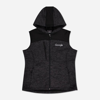

===
{'description': "## Alice, Meet Your New Favorite Layer: The Google Women's Tech Fleece Vest\n\nAlice, are you looking for a versatile layering piece that aligns with your values and elevates your sustainable style? The Google Women's Tech Fleece Vest might be exactly what you've been searching for.\n\nImagine this: it's a crisp autumn morning, you're cycling to your studio, and you need an extra layer to keep you warm without feeling bulky. This lightweight vest is perfect. Not only is it incredibly comfortable thanks to its soft fleece lining, but its water-resistant finish gives you peace of mind if you get caught in a light drizzle.\n\nBut it's more than just comfortable and practical. We know how important sustainability is to you, Alice, and while we're always striving to do better, this vest is a step in the right direction. The durable construction means you'll have this piece in your wardrobe for years to come, reducing the need for fast-fashion alternatives. Plus, the cla

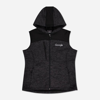

===


In [26]:
personalized = client.collections.get("Personalized")

response = personalized.query.fetch_objects(
    limit=2,
    return_references=[QueryReference(
            link_on="ofProduct", # return the title property from the Product collection
            return_properties=["title", "link"]
        ),
        QueryReference(
            link_on="ofPersona",
            return_properties=["name"] # return the name property from the Persona collection
        )
    ]
)

for item in response.objects:
    print(item.properties)
    for ref_obj in item.references["ofProduct"].objects:
        print(ref_obj.properties)
    for ref_obj in item.references["ofPersona"].objects:
        print(ref_obj.properties)
    display_image(product.properties['link'])
    print("===")

## Notebook Recap

In this notebook, you learned how to:
1. Create a Weaviate cluster using Embedded
2. Define a Weaviate schema and select the embedding and generative model
3. Connect to the Gemini API
4. Perform vector and hybrid search with filtering and autocut
6. Use Generative Feedback Loops to store the output of the language model back to the database for future retrieval
7. Use cross-references to build relationships between collections

You can learn more about Weaviate through our [documentation](https://weaviate.io/developers/weaviate), and you can find more Weaviate and Google cookbooks [here](https://github.com/weaviate/recipes/tree/main/integrations/cloud-hyperscalers/google)!

**Authors: Erika Cardenas and Bob Van Luijt**

Connect with us and let us know if you have any questions!

Erika's accounts:
* [Follow on X](https://x.com/ecardenas300)
* [Connect on LinkedIn](https://www.linkedin.com/in/erikacardenas300/)

Bob's accounts:
* [Follow on X](https://x.com/bobvanluijt)
* [Connect on LinkedIn](https://www.linkedin.com/in/bobvanluijt/)